This notebook is part of a series of notebooks that delve into the comprehensive analysis of order book events. Each notebook in this series focuses on various aspects of order book data, aiming to provide in-depth insights and understanding into the dynamics of financial markets. 

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from functools import partial
from scipy.optimize import curve_fit
import scipy
import statsmodels.api as sm
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#load data
pair = "XCAD-USDT"
exchange = "GATEIO"

start = datetime.datetime(2022, 11, 7)
end = datetime.datetime(2022, 11, 10)

books = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/books_GATEIO_AVAX-USDT_2022-11-01.parquet")
trades = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/trades_GATEIO_AVAX-USDT_2022-11-01.parquet")
# Filter the DataFrame
#books = books[(books['received_time'] >= start) & (books['received_time'] <= end)]
#trades = trades[(trades['received_time'] >= start) & (trades['received_time'] <= end)]

## Market Microstructure

In [3]:
def smallest_increment(number):

    # Convert the number to a string and split by the decimal point
    parts = str(number).split('.')
    
    # If there's a decimal part
    if len(parts) > 1:
        # Count the number of digits after the decimal point
        decimal_places = len(parts[1])
        
        # Return the smallest increment based on the decimal places
        return 10 ** -decimal_places
    else:
        # If there's no decimal, the smallest increment is 1
        return 1

tick_size = smallest_increment(trades["price"].iloc[0])
books['mid'] = (books['bid_0_price'] + books['ask_0_price']) / 2

In [4]:
# delete trades inside of spread:
delete_fake = True

#percentage of trades within spread
def find_closest_timestamp(ts, ts_list):
    """Find the closest timestamp in ts_list to ts."""
    deltas = np.abs((ts_list - ts).total_seconds())
    return ts_list[np.argmin(deltas)]
    target = row.name + pd.Timedelta(seconds=5)
    return ts_index.get_loc(target, method='nearest')

tick_size = smallest_increment(trades["price"].iloc[0])
book1 = books.copy()
# Merge trades and l1 data
book1['future_bid'] = book1.bid_0_price.shift(-1)
book1['future_ask'] = book1.ask_0_price.shift(-1)
# book1['mid_future_5s'] = book1.mid.shift(-5)

df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = book1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)

# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

trades = df[["side","quantity","price","trade_received_time", "origin_time_x", "fake", "trade_id"]]
trades["received_time"] =trades["trade_received_time"]

if delete_fake:
    print("drop fake trades!")
    trades = trades[~trades["fake"]]

Fake trade percentage 18.352516098953934
Fake volume percentage 39.51776397408518
drop fake trades!


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_4304/1080341533.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["received_time"] =trades["trade_received_time"]


## impact of a trade

In [5]:
combined_df = pd.concat([books, trades], ignore_index=True) #concat all rows

trades_impact_df = combined_df.sort_values(by='received_time')

In [6]:
trades_impact_df["mid"] = trades_impact_df["mid"].ffill()

trades_impact_df.set_index('received_time', inplace=True)
trades_impact_df = trades_impact_df.sort_index()

def get_future_mid(row, seconds):
    future_timestamp = row.name + pd.Timedelta(seconds=seconds)
    # Use the asof method to find the closest previous mid value
    future_value = trades_impact_df['mid'].asof(future_timestamp)
    return future_value

# Create a mask for rows where trade_id is not NaN
trade_id_mask = trades_impact_df['trade_id'].notna()

# Loop through each time interval and create the new columns
for seconds in [1, 10, 100, 1000]:
    column_name = f'future_mid_{seconds}s'
    # Apply the function only to rows where trade_id is not NaN
    trades_impact_df.loc[trade_id_mask, column_name] = trades_impact_df[trade_id_mask].apply(lambda row: get_future_mid(row, seconds), axis=1)

In [7]:
#delet non trades
trades_impact_df = trades_impact_df[trades_impact_df['trade_id'].notna()]

#calc difference
# Loop through each time interval and create the new columns
for seconds in [1, 10, 100, 1000]:
    trades_impact_df[f'return_mid_{seconds}s'] = (trades_impact_df[f'future_mid_{seconds}s'] - trades_impact_df["mid"] )/tick_size

    


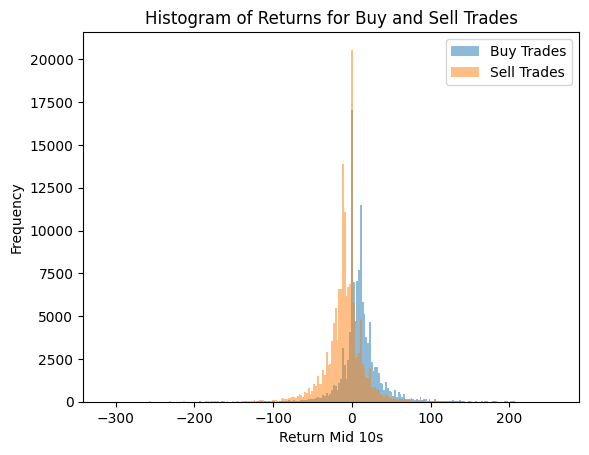

In [22]:

buy_trades = trades_impact_df[trades_impact_df['side'] == 'buy']
sell_trades = trades_impact_df[trades_impact_df['side'] == 'sell']


plt.hist(buy_trades['return_mid_10s'], bins=250, alpha=0.5, label='Buy Trades')
plt.hist(sell_trades['return_mid_10s'], bins=250, alpha=0.5, label='Sell Trades')


plt.xlabel('Return Mid 10s')
plt.ylabel('Frequency')
plt.title('Histogram of Returns for Buy and Sell Trades')
plt.legend()
plt.show()

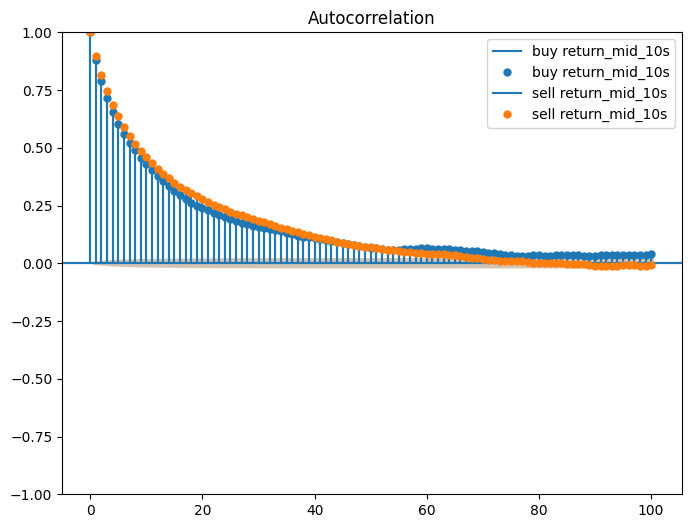

In [10]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(buy_trades['return_mid_10s'][-100000:], lags=100, ax=ax, label='buy return_mid_10s')
sm.graphics.tsa.plot_acf(sell_trades['return_mid_10s'][-100000:], lags=100, ax=ax, label='sell return_mid_10s')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

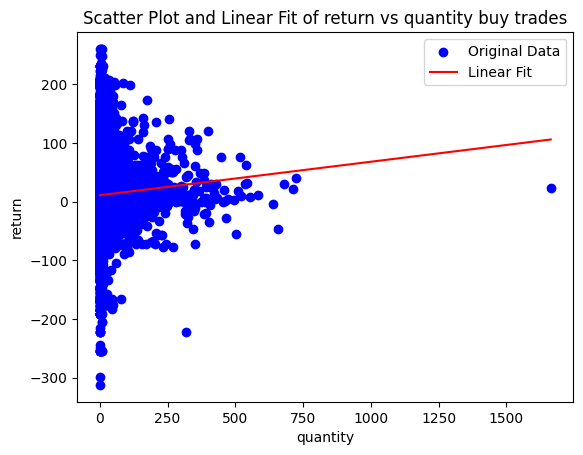

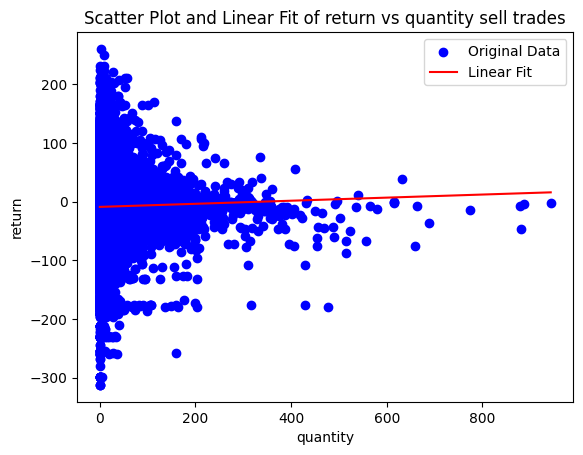

In [23]:

# Define the linear fit function
def lin_fit(x, a, b):
    return a * x + b

return_ = np.array(buy_trades['return_mid_10s'])
quantity = np.array(buy_trades['quantity'])

# Fit the data using curve_fit
params, _ = curve_fit(lin_fit, quantity, return_ )
x_fit = np.linspace(min(quantity), max(quantity), 100)
y_fit = lin_fit(x_fit, *params)

# Create the scatter plot for original data
plt.scatter(quantity, return_ , label='Original Data', color='blue')
plt.xlabel("quantity")
plt.ylabel("return")
plt.title("Scatter Plot and Linear Fit of return vs quantity buy trades")

# Plot the fitted curve
plt.plot(x_fit, y_fit, label='Linear Fit', color='red')
plt.legend()
plt.show()



return_ = np.array(sell_trades['return_mid_10s'])
quantity = np.array(sell_trades['quantity'])

# Fit the data using curve_fit
params, _ = curve_fit(lin_fit, quantity, return_ )
x_fit = np.linspace(min(quantity), max(quantity), 100)
y_fit = lin_fit(x_fit, *params)

# Create the scatter plot for original data
plt.scatter(quantity, return_ , label='Original Data', color='blue')
plt.xlabel("quantity")
plt.ylabel("return")
plt.title("Scatter Plot and Linear Fit of return vs quantity sell trades")

# Plot the fitted curve
plt.plot(x_fit, y_fit, label='Linear Fit', color='red')
plt.legend()
plt.show()

In [12]:
books.set_index('received_time', inplace=True)
books.index = pd.to_datetime(books.index)
resampled_mids = pd.DataFrame()
resampled_mids["mid"] = books["mid"].resample("1S").mean().ffill()
books = books.reset_index()

resampled_mids["return"] = resampled_mids["mid"] - resampled_mids["mid"].shift(+1) 
resampled_mids["return"].mean()/tick_size


-0.0027145515332748335

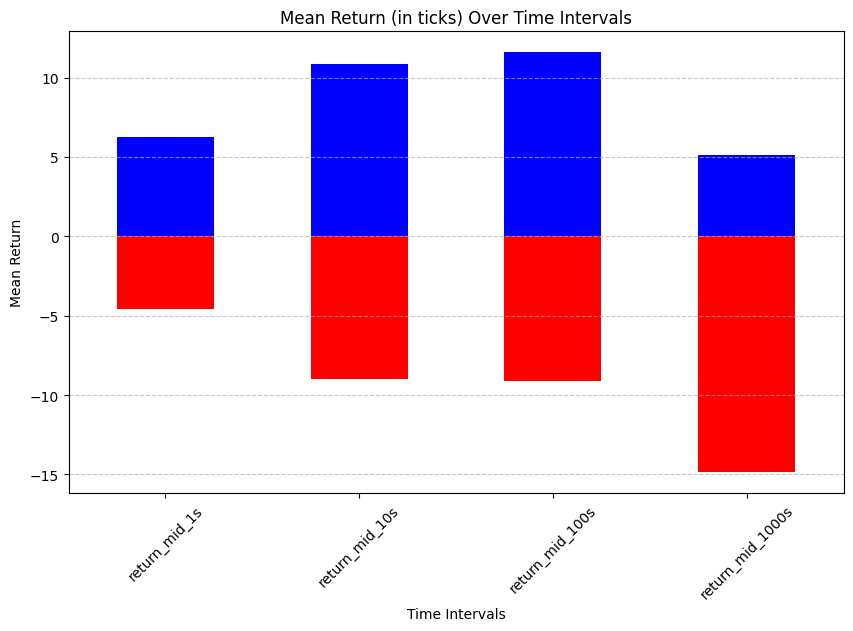

In [13]:
#mean impact over time
columns = ['return_mid_1s', 'return_mid_10s', 'return_mid_100s', 'return_mid_1000s']
means_buy = buy_trades[columns].mean()
means_sell = sell_trades[columns].mean()

# Now create the bar chart
plt.figure(figsize=(10,6))  # Optional: Set the figure size
means_buy.plot(kind='bar', color='blue')
means_sell.plot(kind='bar', color='red')
plt.title('Mean Return (in ticks) Over Time Intervals')
plt.ylabel('Mean Return')
plt.xlabel('Time Intervals')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add a grid for better readability
plt.show()

In [14]:
#trades count imbalance

def weighted_avg_price(group):
    weighted_sum = (group['price'] * group['quantity']).sum()
    total_sum = group['quantity'].sum()
    return weighted_sum / total_sum if total_sum != 0 else 0

def group_operations(group):
    return pd.Series({
        "received_time": group['received_time'].iloc[0],
        'sum_quantity': group['quantity'].sum(),
        'new_price': weighted_avg_price(group),
        'side': group['side'].iloc[0]  # Take the first 'side' value within each group
    })

grouped = trades.groupby('origin_time_x')
aggregated_df = grouped.apply(group_operations)

# Reset the index of the aggregated DataFrame
aggregated_df.reset_index(inplace=True)

In [15]:

window_size = 30

#count
aggregated_df['is_sell'] = (aggregated_df['side'] == 'sell').astype(int)
aggregated_df['is_buy'] = (aggregated_df['side'] == 'buy').astype(int)

aggregated_df['rolling_buy_count'] = aggregated_df['is_buy'].rolling(window_size).sum()
aggregated_df['rolling_sell_count'] = aggregated_df['is_sell'].rolling(window_size).sum()


#amount
aggregated_df['sell_amount'] = np.where(aggregated_df['side'] == 'sell',aggregated_df['sum_quantity'],0)
aggregated_df['buy_amount'] = np.where(aggregated_df['side'] == 'buy',aggregated_df['sum_quantity'],0)

aggregated_df['rolling_buy_amount'] = aggregated_df['buy_amount'].rolling(window_size).sum()
aggregated_df['rolling_sell_amount'] = aggregated_df['sell_amount'].rolling(window_size).sum()

aggregated_df['trade_count_imbalance'] = (aggregated_df["rolling_buy_count"]-aggregated_df["rolling_sell_count"])/(aggregated_df["rolling_buy_count"]+aggregated_df["rolling_sell_count"])
aggregated_df['trade_amount_imbalance'] = (aggregated_df["rolling_buy_amount"]-aggregated_df["rolling_sell_amount"])/(aggregated_df["rolling_buy_amount"]+aggregated_df["rolling_sell_amount"])

In [16]:
#merge back to books
aggregated_df.set_index('received_time', inplace=True)

#delet if allready in books
for col in ["trade_amount_imbalance","trade_count_imbalance"]:
    if col in books.columns:
        books.drop(col, axis=1, inplace=True)

books = pd.merge_asof(books, aggregated_df[["trade_amount_imbalance","trade_count_imbalance"]], on='received_time', direction='backward') #backward-> no future information


aggregated_df = aggregated_df.reset_index()

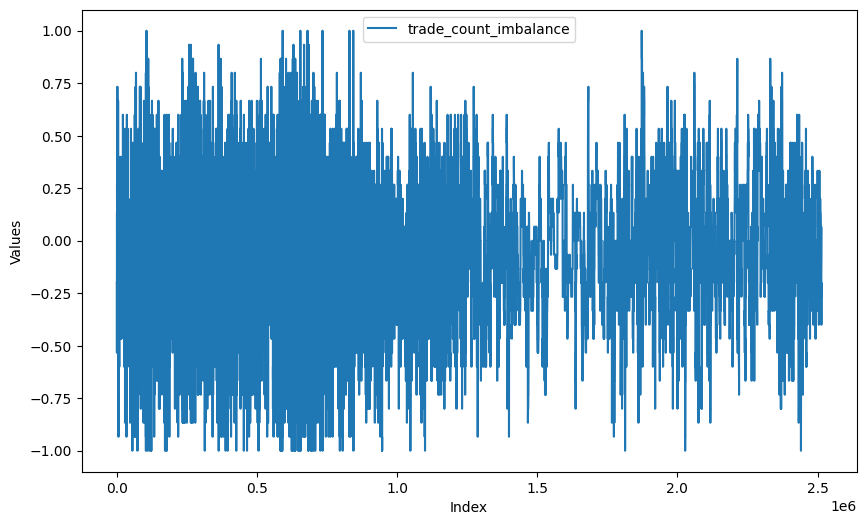

In [17]:
columns_to_plot = ["trade_count_imbalance"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

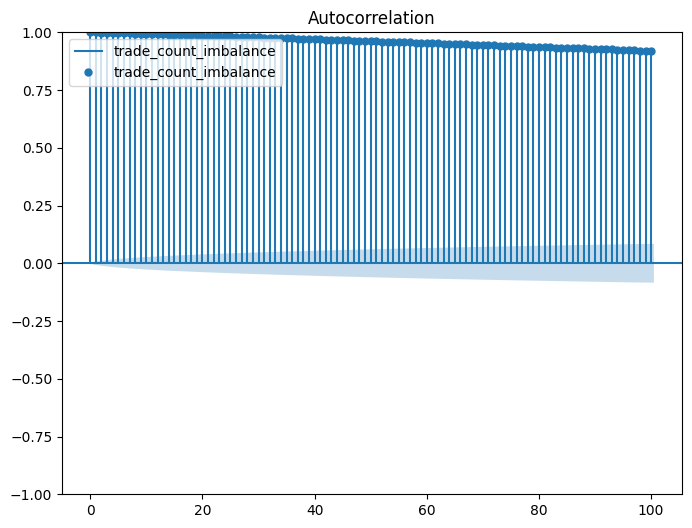

In [18]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['trade_count_imbalance'][-100000:], lags=100, ax=ax, label='trade_count_imbalance')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

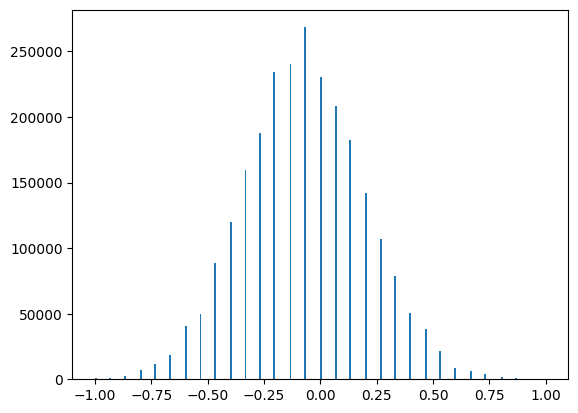

In [19]:
#Now let’s look at it’s distribution:
plt.hist([books['trade_count_imbalance']], bins=250)
plt.show()

/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_4304/750922412.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values


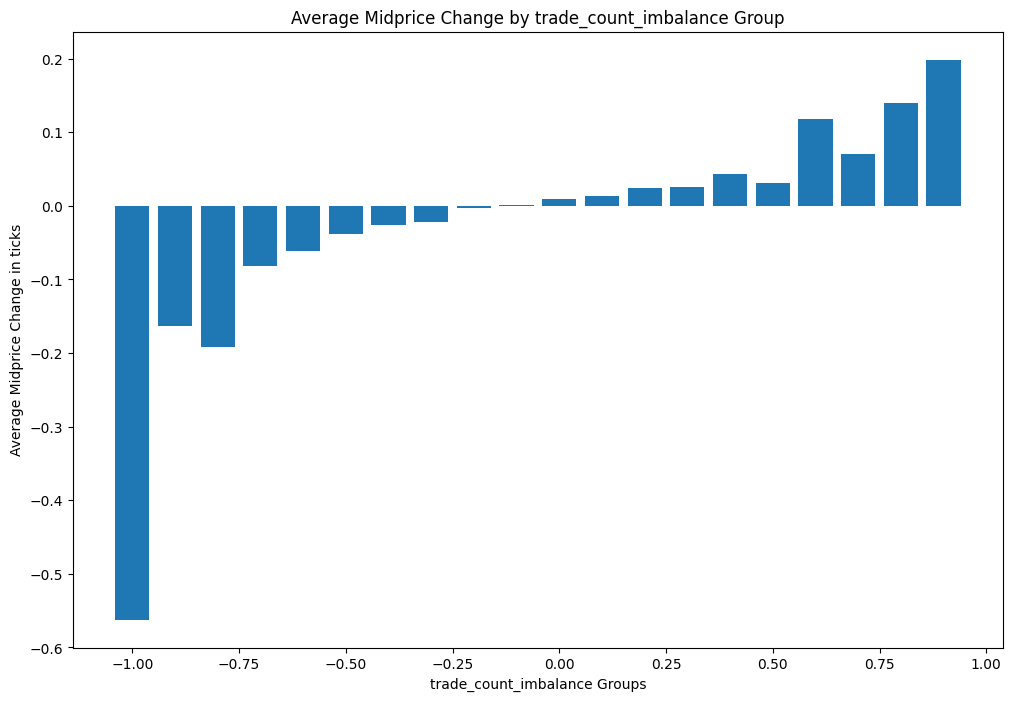

In [20]:
b_imbalance = np.array(books['trade_count_imbalance'])
midprices = np.array(books['mid'])
midprice_change = midprices[1:]-midprices[:-1]

#lets look at the avg midprice change for these vpin buckets
df = pd.DataFrame({'b_imbalance': b_imbalance[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['b_imbalance_group'] = pd.cut(df['b_imbalance'], bins=bins)
midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values

# Your imbalance_groups remain the same
imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08)  # Adjusted width to match new granularity
plt.xlabel('trade_count_imbalance Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by trade_count_imbalance Group')
plt.show()

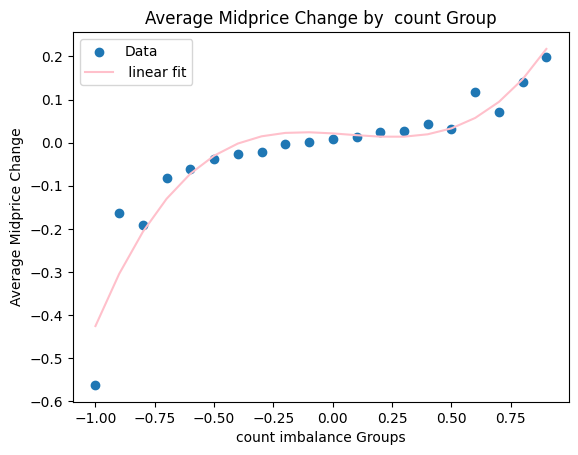

[ 0.40487128 -0.08021816 -0.03790729  0.02147707]


In [21]:
# Define the function to fit
def linear(x, m, b):
    return m*x + b

def poly3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Prepare the data
xdata = imbalance_groups
ydata = midprice_averages


# Fit the curve
popt3, _ = curve_fit(poly3, xdata, ydata)
y_fit3 = poly3(xdata, *popt3)



# Plot the original data and the fitted curve
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, y_fit3, label=' linear fit', color='pink')

plt.xlabel('count imbalance Groups')
plt.ylabel('Average Midprice Change')
plt.title('Average Midprice Change by  count Group')
plt.legend()

plt.show()
print(popt3)
